In [5]:
import numpy as np
from PIL import Image
import jax
import flax
import flax.linen as nn

In [10]:
x = np.random.randn(32,1,8,8,3)

In [8]:
x.shape

(32, 8, 8, 3)

In [12]:
net = nn.Conv(features=512,kernel_size=(3,3),strides=(1,1),padding='same')(x)

CallCompactUnboundModuleError: Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.CallCompactUnboundModuleError)

In [2]:
## Einops
import numpy as np

from PIL.Image import fromarray
from IPython import get_ipython


def display_np_arrays_as_images():
    def np_to_png(a):
        if 2 <= len(a.shape) <= 3:
            return fromarray(np.array(np.clip(a, 0, 1) * 255, dtype='uint8'))._repr_png_()
        else:
            return fromarray(np.zeros([1, 1], dtype='uint8'))._repr_png_()

    def np_to_text(obj, p, cycle):
        if len(obj.shape) < 2:
            print(repr(obj))
        if 2 <= len(obj.shape) <= 3:
            pass
        else:
            print('<array of shape {}>'.format(obj.shape))

    get_ipython().display_formatter.formatters['image/png'].for_type(np.ndarray, np_to_png)
    get_ipython().display_formatter.formatters['text/plain'].for_type(np.ndarray, np_to_text)


from IPython.display import display_html

_style_inline = """<style>
.einops-answer {
    color: transparent;
    padding: 5px 15px;
    background-color: #def;
}
.einops-answer:hover { color: blue; } 
</style>
"""


def guess(x):
    display_html(
        _style_inline
        + "<h4>Answer is: <span class='einops-answer'>{x}</span> (hover to see)</h4>".format(x=tuple(x)),
        raw=True)
        
import einops
import numpy as np
from PIL import Image
display_np_arrays_as_images()

In [3]:
import glob
filelist = glob.glob('../../lfw/lfw-deepfunneled/lfw-deepfunneled/Angela_Bassett/*.jpg')

In [4]:
all_images = (np.array([np.array(Image.open(fname)) for fname in filelist]))/255

In [5]:
print(all_images.shape, all_images.dtype)

(6, 250, 250, 3) float64


In [15]:
len(all_images)

6

In [16]:
from einops import rearrange, reduce, repeat

In [30]:
all_patches = rearrange(all_images[0], '(nh hp) (nw wp) c -> (nh nw) hp wp c ', hp=50, wp=50) ##normal conv

In [63]:
all_patches.shape

(25, 50, 50, 3)

In [ ]:

    print(chosen.shape)
    print(rest.shape)

In [7]:
import os

In [12]:
##tr = rearrange(all_images[0], '(h1 h2) (w1 w2) c -> (h1 w2) (w1 h2) c', h2=25, w2=25)

In [24]:
tr = rearrange(all_images[0], '(nh hp) (nw wp) c -> (hp wp) nh nw c ', hp=5, wp=5) ##dilated conv

In [14]:
tr = rearrange(all_images[0], '(nh hp) (nw wp) c -> (nh nw) hp wp c ', hp=25, wp=25) ##normal conv

In [23]:
tr

<array of shape (100, 25, 25, 3)>


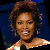

In [25]:
tr[8]

In [17]:
x_p = rearrange(all_images[0], '(h p1) (w p2) c -> (h w) (p1 p2) c', p1 = 50, p2 = 50)

In [18]:
x_p

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.02352941, 0.09803922],
        [0.        , 0.01960784, 0.0745098 ],
        [0.        , 0.02352941, 0.0745098 ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.15294118, 0.11372549, 0.0745098 ],
        [0.13333333, 0.09411765, 0.05490196],
        [0.10588235, 0.06666667, 0.02745098]],

       [[0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.01176471, 0.01568627, 0.02352941],
        ...,
        [0.03921569, 0.02745098, 0.        ],
        [0.03921569, 0.02745098, 0.        ],
        [0.04705882, 0.02745098, 0.00392157]],

       ...,

       [[0.54117647, 0.39215686, 0.30980392],
        [0.50980392, 0.3372549 , 0.23921569],
        [0.50980392, 0

In [19]:
x_p.shape

(25, 2500, 3)

In [ ]:
image = rearrange(all_images[0], 'b (c h w) -> b c (h w)', h=4, w=4)

# Assign each patch a value between 0 and 15
for i in range(16):
    image[:, i] += i

# Reshape the patches back into a single image
reassembled_image = einops.rearrange(image, 'b c (h w) -> b (c h w)', h=4, w=4)

In [5]:
import flax.optim

In [6]:
class Dequantization(nn.Module):
    
    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input. 
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants 
        
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            #ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = np.floor(z).clamp(min=0, max=self.quants-1).to(np.int32)
        return z, ldj
    
    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            #ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = flax.optim.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-np.log(z) - np.log(1-z)).sum(dim=[1,2,3])
            z = np.log(z) - np.log(1-z)
        return z, ldj
    
    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(np.float32)
        z = z + np.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

In [14]:
import numpy as np

In [13]:
sigma = np.random.randn(1).repeat([3, 5, 5], axis=0)
patches = np.random.randn(3, 5, 5)

ValueError: operands could not be broadcast together with shape (1,) (3,)

In [6]:
np.multiply(sigma,patches)

ValueError: operands could not be broadcast together with shapes (1,3) (3,5,5) 